In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [3]:
dataset_path = './dataset'
samples = 25
covid_dataset_path = './origin'
# read  "metadata.csv" and find the target image
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
for (i, row) in df.iterrows():
    # check the current case is not COVID-19 
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue
# set the picture path for reading.
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])
# if the input image file does not exist
    if not os.path.exists(imagePath):
        continue
# get the name and set the new location for train 
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])
# copy the image to location
    shutil.copy2(imagePath, outputPath)

In [4]:
#normal資料集我是用手動下載
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [17]:
print(len(normal_images), len(covid_images))

36 141


In [10]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [11]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(rotation_range=20, fill_mode="nearest")

In [12]:
baseModel = VGG16(weights="./vgg16_weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
# if set false means the parameters in the layer will not change
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
record  = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/10
17/17 [==============================] - 51s 3s/step - loss: 0.4721 - accuracy: 0.7895 - val_loss: 0.4066 - val_accuracy: 0.8056
Epoch 2/10
17/17 [==============================] - 51s 3s/step - loss: 0.4382 - accuracy: 0.8045 - val_loss: 0.3500 - val_accuracy: 0.8056
Epoch 3/10
17/17 [==============================] - 50s 3s/step - loss: 0.3554 - accuracy: 0.8496 - val_loss: 0.2947 - val_accuracy: 0.9444
Epoch 4/10
17/17 [==============================] - 52s 3s/step - loss: 0.2524 - accuracy: 0.8947 - val_loss: 0.2538 - val_accuracy: 0.9444
Epoch 5/10
17/17 [==============================] - 49s 3s/step - loss: 0.2337 - accuracy: 0.9173 - val_loss: 0.2270 - val_accuracy: 0.9722
Epoch 6/10
17/17 [==============================] - 47s 3s/step - loss: 0.1946 - accuracy: 0.9624 - val_loss: 0.2069 - val_accuracy: 0.9722
Epoch 7/10
17/17 [==============================] - 46s 3s/step - loss: 0.1442 - accuracy: 0.9699 - val_loss: 0.1796 - val_accuracy: 0.9722
Epoch 8/10
17/17 [==

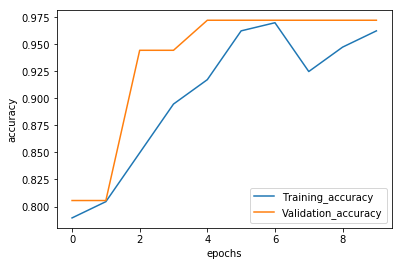

In [15]:
accs = record.history['accuracy']
val_accs = record.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

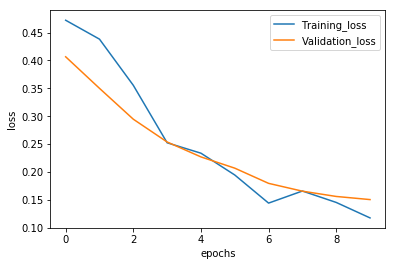

In [16]:
loss = record.history['loss']
val_loss = record.history['val_loss']

plt.plot(range(len(accs)),loss, label = 'Training_loss')
plt.plot(range(len(accs)),val_loss, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
model.save('./vgg16_weight/covid_19_model.h5')